In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pip install scipy


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# from natsort import natsorted
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# import shap
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.transform import Rotation as R
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.signal import correlate
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import entropy
from scipy.stats import kurtosis, skew
from scipy.fft import fft, fftfreq
from scipy.stats import iqr


In [4]:
# a()

In [5]:
def zero_crossing_rate(signal):
    """Tính số lần tín hiệu cắt qua 0"""
    return np.sum(np.diff(np.sign(signal)) != 0)

def calculate_elbow_angle_quat(window, upper_sensor, wrist_sensor):
    """Tính góc khuỷu tay cho từng cửa sổ sử dụng quaternion"""
    upper_quat = window[[f'{upper_sensor}/quat_x', f'{upper_sensor}/quat_y',
                         f'{upper_sensor}/quat_z', f'{upper_sensor}/quat_w']].values
    wrist_quat = window[[f'{wrist_sensor}/quat_x', f'{wrist_sensor}/quat_y',
                         f'{wrist_sensor}/quat_z', f'{wrist_sensor}/quat_w']].values

    vec_upper = R.from_quat(upper_quat).apply([0, 0, 1])
    vec_wrist = R.from_quat(wrist_quat).apply([0, 0, 1])

    dot = np.einsum('ij,ij->i', vec_upper, vec_wrist)
    norm = np.linalg.norm(vec_upper, axis=1) * np.linalg.norm(vec_wrist, axis=1) + 1e-8
    return np.degrees(np.arccos(np.clip(dot/norm, -1, 1))).mean()

def window_feature_extraction(window):
    """Trích xuất tất cả các đặc trưng cho từng cửa sổ"""
    features = {}
    sensors = ['atr01', 'atr02', 'atr03', 'atr04']

    # Các trục dữ liệu cần tính toán cho cả gia tốc và con quay hồi chuyển
    signal_axes = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

    for s in sensors:
        # Tính độ lớn (magnitude) cho acc và gyro
        acc_mag = np.sqrt(window[f'{s}/acc_x']**2 +
                          window[f'{s}/acc_y']**2 +
                          window[f'{s}/acc_z']**2)
        gyro_mag = np.sqrt(window[f'{s}/gyro_x']**2 +
                           window[f'{s}/gyro_y']**2 +
                           window[f'{s}/gyro_z']**2)

        # Tứ phân vị cho acc_mag
        features[f'{s}/acc_mag_q25'] = np.percentile(acc_mag, 25)
        features[f'{s}/acc_mag_q75'] = np.percentile(acc_mag, 75)

        # Statistical summary
        features[f'{s}/acc_mag_avg'] = acc_mag.mean()
        features[f'{s}/gyro_mag_avg'] = gyro_mag.mean()

        # Jerk và tứ phân vị của jerk
        jerk = acc_mag.diff().dropna() * 30
        features[f'{s}/jerk_mean'] = jerk.mean() if len(jerk)>0 else 0
        features[f'{s}/jerk_q25'] = np.percentile(jerk, 25) if len(jerk)>0 else 0
        features[f'{s}/jerk_q75'] = np.percentile(jerk, 75) if len(jerk)>0 else 0


        # Duyệt qua từng trục của sensor
        for ax in signal_axes:
            signal = window[f'{s}/{ax}'].values

            features[f'{s}/{ax}_mean'] = window[f'{s}/{ax}'].mean()
            features[f'{s}/{ax}_std'] = window[f'{s}/{ax}'].std()
            features[f'{s}/{ax}_median'] = window[f'{s}/{ax}'].median()
            features[f'{s}/{ax}_kurtosis'] = kurtosis(signal)
            features[f'{s}/{ax}_skewness'] = skew(signal)
            features[f'{s}/{ax}_zcr'] = zero_crossing_rate(signal)

        # Tính các đặc trưng cho magnitude
        # Chúng ta tính median, kurtosis, skewness, và zcr cho acc_mag và gyro_mag
        for mag, label in zip([acc_mag, gyro_mag], ['acc_mag', 'gyro_mag']):
            features[f'{s}/{label}_median'] = np.median(mag)
            features[f'{s}/{label}_kurtosis'] = kurtosis(mag)
            features[f'{s}/{label}_skewness'] = skew(mag)
            # features[f'{s}/{label}_zcr'] = zero_crossing_rate(mag) ############################################

    # 2. Góc khuỷu tay
    features.update({
        'elbow_angle_right': calculate_elbow_angle_quat(window, 'atr03', 'atr01'),
        'elbow_angle_left': calculate_elbow_angle_quat(window, 'atr04', 'atr02')
    })

    # 3. Độ trễ tương quan chéo
    def _calc_lag(s1, s2, axis='acc_z'):
        x = window[f'{s1}/{axis}'].values
        y = window[f'{s2}/{axis}'].values
        if len(x) < 10 or len(y) < 10:
            return 0
        corr = correlate(x - x.mean(), y - y.mean(), mode='valid')
        return np.argmax(corr) - len(y) + 1

    features.update({
        'lag_right_arm': _calc_lag('atr03', 'atr01'),
        'lag_left_arm': _calc_lag('atr04', 'atr02')
    })

    # 4. Đặc trưng tần số và entropy
    for s in sensors:
        sig = window[f'{s}/acc_x'].values
        if len(sig) > 10:
            fft_vals = np.abs(fft(sig))
            features[f'{s}/dominant_freq'] = np.argmax(fft_vals[:len(fft_vals)//2])
        else:
            features[f'{s}/dominant_freq'] = 0

    # 5. Đặc trưng động học nâng cao
    for s in ['atr01', 'atr02']:
        roll = window[f'{s}/roll'].values
        features[f'{s}/wrist_stability'] = roll.std() if len(roll) > 1 else 0

    # 6. Đặc trưng rolling
    window_cp = window.copy()
    for i in [1, 2]:
        sensor = f'atr0{i}'
        window_cp[f'{sensor}/wrist_stability'] = window_cp[f'{sensor}/roll'].rolling(window=10, min_periods=1).std().values
        window_cp[f'{sensor}/stillness'] = (window_cp[f'{sensor}/gyro_mag'] < 5).rolling(window=15, min_periods=1).sum().values

    # Lấy giá trị cuối cùng của các đặc trưng rolling
    last_row = window_cp.iloc[-1]
    for col in window_cp.columns:
        if 'stability' in col or 'stillness' in col:
            features[col] = last_row[col]

    return features


def process_pipeline(data_path, window_size=30, step_size=15):
    """Pipeline xử lý hoàn chỉnh"""
    df = pd.read_csv(data_path)
    df = df.drop(['Unnamed: 0', 'action'], axis = 1)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # Tiền xử lý cơ bản
    for i in range(1, 5):
        df[f'atr0{i}/acc_mag'] = np.sqrt(df[f'atr0{i}/acc_x']**2 +
                                        df[f'atr0{i}/acc_y']**2 +
                                        df[f'atr0{i}/acc_z']**2)
        df[f'atr0{i}/gyro_mag'] = np.sqrt(df[f'atr0{i}/gyro_x']**2 +
                                         df[f'atr0{i}/gyro_y']**2 +
                                         df[f'atr0{i}/gyro_z']**2)

    features = []
    labels = []

    for start in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[start:start+window_size].copy()

        # Tính toán các đặc trưng động trong cửa sổ
        window = calculate_window_features(window)
        feats = window_feature_extraction(window)

        features.append(feats)
        labels.append(window['operation'].mode()[0])

    return pd.DataFrame(features).assign(operation=labels)

def calculate_window_features(window):
    """Tính toán các đặc trưng phụ thuộc thời gian trong cửa sổ"""
    # Tính toán Euler angles
    for i in [1, 2]:
        quat = window[[f'atr0{i}/quat_x', f'atr0{i}/quat_y',
                     f'atr0{i}/quat_z', f'atr0{i}/quat_w']].values
        euler = R.from_quat(quat).as_euler('xyz', degrees=True)
        window[f'atr0{i}/roll'] = euler[:, 0]
        window[f'atr0{i}/pitch'] = euler[:, 1]
        window[f'atr0{i}/yaw'] = euler[:, 2]

    # Các tính toán khác
    window['acc_mag_diff_01_02'] = window['atr01/acc_mag'] - window['atr02/acc_mag']
    window['pseudo_torque_right'] = (window['atr03/gyro_mag'] - window['atr01/gyro_mag']) * (window['atr03/acc_mag'] + window['atr01/acc_mag']) * 0.3

    return window

In [6]:

# def zero_crossing_rate(signal):
#     """Tính số lần tín hiệu cắt qua 0"""
#     return np.sum(np.diff(np.sign(signal)) != 0)


# def calculate_elbow_angle_quat(window, upper_sensor, wrist_sensor):
#     """Tính góc khuỷu tay cho từng cửa sổ sử dụng quaternion"""
#     upper_quat = window[[f'{upper_sensor}/quat_x', f'{upper_sensor}/quat_y',
#                          f'{upper_sensor}/quat_z', f'{upper_sensor}/quat_w']].values
#     wrist_quat = window[[f'{wrist_sensor}/quat_x', f'{wrist_sensor}/quat_y',
#                          f'{wrist_sensor}/quat_z', f'{wrist_sensor}/quat_w']].values

#     vec_upper = R.from_quat(upper_quat).apply([0, 0, 1])
#     vec_wrist = R.from_quat(wrist_quat).apply([0, 0, 1])

#     dot = np.einsum('ij,ij->i', vec_upper, vec_wrist)
#     norm = np.linalg.norm(vec_upper, axis=1) * np.linalg.norm(vec_wrist, axis=1) + 1e-8
#     return np.degrees(np.arccos(np.clip(dot/norm, -1, 1))).mean()


# def window_feature_extraction_v3(window, sampling_rate=30):
#     """Trích xuất đặc trưng cho từng cửa sổ, bổ sung RMS và range để đưa lên ~250 features"""
#     features = {}
#     sensors = ['atr01', 'atr02', 'atr03', 'atr04']
#     signal_axes = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

#     for s in sensors:
#         acc_mag = np.sqrt(window[f'{s}/acc_x']**2 +
#                           window[f'{s}/acc_y']**2 +
#                           window[f'{s}/acc_z']**2)
#         gyro_mag = np.sqrt(window[f'{s}/gyro_x']**2 +
#                            window[f'{s}/gyro_y']**2 +
#                            window[f'{s}/gyro_z']**2)

#         features[f'{s}/acc_mag_mean'] = acc_mag.mean()
#         features[f'{s}/gyro_mag_mean'] = gyro_mag.mean()
#         features[f'{s}/jerk'] = acc_mag.diff().mean() * sampling_rate

#         for ax in signal_axes:
#             sig = window[f'{s}/{ax}'].values
#             features[f'{s}/{ax}_mean'] = np.mean(sig)
#             features[f'{s}/{ax}_std'] = np.std(sig)
#             features[f'{s}/{ax}_median'] = np.median(sig)
#             features[f'{s}/{ax}_kurtosis'] = kurtosis(sig)
#             features[f'{s}/{ax}_skewness'] = skew(sig)
#             features[f'{s}/{ax}_zcr'] = zero_crossing_rate(sig)
#             # Bổ sung RMS và range
#             features[f'{s}/{ax}_rms'] = np.sqrt(np.mean(sig**2))
#             features[f'{s}/{ax}_range'] = np.max(sig) - np.min(sig)

#         # magnitude details (no zcr for magnitude features)
#         for mag, label in zip([acc_mag, gyro_mag], ['acc_mag', 'gyro_mag']):
#             features[f'{s}/{label}_median'] = np.median(mag)
#             features[f'{s}/{label}_kurtosis'] = kurtosis(mag)
#             features[f'{s}/{label}_skewness'] = skew(mag)

#     # elbow angles
#     features['elbow_angle_right'] = calculate_elbow_angle_quat(window, 'atr03', 'atr01')
#     features['elbow_angle_left']  = calculate_elbow_angle_quat(window, 'atr04', 'atr02')

#     # lag
#     def _calc_lag(s1, s2, axis='acc_z'):
#         x = window[f'{s1}/{axis}'].values
#         y = window[f'{s2}/{axis}'].values
#         if len(x) < 10: return 0
#         corr = correlate(x - x.mean(), y - y.mean(), mode='valid')
#         return np.argmax(corr) - len(y) + 1

#     features['lag_right_arm'] = _calc_lag('atr03', 'atr01')
#     features['lag_left_arm']  = _calc_lag('atr04', 'atr02')

#     # dominant freq
#     for s in sensors:
#         sig = window[f'{s}/acc_x'].values
#         if len(sig) > 10:
#             fft_vals = np.abs(fft(sig))
#             features[f'{s}/dominant_freq'] = np.argmax(fft_vals[:len(fft_vals)//2])
#         else:
#             features[f'{s}/dominant_freq'] = 0

#     # wrist stability
#     for s in ['atr01', 'atr02']:
#         roll = window[f'{s}/roll'].values
#         features[f'{s}/wrist_stability'] = roll.std() if len(roll) > 1 else 0

#     # rolling features
#     window_cp = window.copy()
#     for i in [1, 2]:
#         sensor = f'atr0{i}'
#         window_cp[f'{sensor}/wrist_stability'] = window_cp[f'{sensor}/roll'].rolling(window=10, min_periods=1).std()
#         window_cp[f'{sensor}/stillness'] = (window_cp[f'{sensor}/gyro_mag'] < 5).rolling(window=15, min_periods=1).sum()
#     last = window_cp.iloc[-1]
#     for col in window_cp.columns:
#         if 'stability' in col or 'stillness' in col:
#             features[col] = last[col]

#     return features


# def process_pipeline_v3(data_path, window_size=30, step_size=15):
#     df = pd.read_csv(data_path)
#     df = df.drop(['Unnamed: 0', 'action'], axis=1)
#     df.ffill(inplace=True); df.bfill(inplace=True)

#     # pre-compute magnitude and quaternion features
#     df = calculate_window_features(df)

#     feats, labels = [], []
#     for start in range(0, len(df) - window_size + 1, step_size):
#         window = df.iloc[start:start+window_size].copy()
#         feats.append(window_feature_extraction_v3(window))
#         labels.append(window['operation'].mode()[0])

#     return pd.DataFrame(feats).assign(operation=labels)


In [7]:
gendata =  ['/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_1.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_2.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_3.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_4.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_5.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_6.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_7.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_8.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_9.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_10.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_11.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_12.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_13.csv']

In [8]:
data_train_file_1       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_1.csv')
data_train_file_4       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_4.csv')
data_train_file_5       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_5.csv')
data_train_file_6       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_6.csv')
data_train_file_7       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_7.csv')
data_train_file_8       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_8.csv')
data_train_file_9       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_9.csv')
data_train_file_10      = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_10.csv')
data_train_file_11      = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_11.csv')
data_train_file_12      = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_12.csv')
data_train_file_13      = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_13.csv')




data_test_file_2        = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_2.csv')
data_test_file_3        = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_3.csv')



In [9]:
train_dfs = [
    data_train_file_1,
    data_train_file_4,
    data_train_file_5,
    data_train_file_6,
    data_train_file_7,
    data_train_file_8,
    data_train_file_9,
    data_train_file_10,
    data_train_file_11,
    data_train_file_12,
    data_train_file_13
]

data_train = pd.concat(train_dfs, ignore_index=True)



In [10]:
data_test = pd.concat([data_test_file_2, data_test_file_3], ignore_index=True)

In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50419 entries, 0 to 50418
Columns: 209 entries, atr01/acc_mag_q25 to operation
dtypes: float64(178), int64(31)
memory usage: 80.4 MB


In [12]:
data_train.head()

,atr01/acc_mag_q25,atr01/acc_mag_q75,atr01/acc_mag_avg,atr01/gyro_mag_avg,atr01/jerk_mean,atr01/jerk_q25,atr01/jerk_q75,atr01/acc_x_mean,atr01/acc_x_std,atr01/acc_x_median,...,lag_left_arm,atr01/dominant_freq,atr02/dominant_freq,atr03/dominant_freq,atr04/dominant_freq,atr01/wrist_stability,atr02/wrist_stability,atr01/stillness,atr02/stillness,operation
0,0.912653,1.218340,1.065149,130.811351,-0.066157,-6.856812,8.691861,0.714973,0.437179,0.81225,...,-29,0,0,0,0,43.247316,64.058235,1.0,0.0,100
1,0.970562,1.145820,1.039036,85.258319,0.308363,-3.923431,4.258086,0.799407,0.344473,0.91795,...,-29,0,0,0,0,54.657517,97.460434,0.0,0.0,100
2,0.977219,1.138767,1.020553,74.544164,-0.119560,-3.826800,2.891186,0.785223,0.250121,0.82055,...,-29,0,0,0,0,36.375185,30.361599,0.0,0.0,100
3,0.970795,1.061048,1.041770,71.657631,-0.284668,-3.147783,2.891186,0.670063,0.281651,0.69370,...,-29,0,0,0,0,21.723514,51.943404,0.0,0.0,100
4,0.962727,1.064016,1.036813,84.055072,-0.502104,-2.800714,1.919917,0.614697,0.348889,0.62625,...,-29,0,0,0,0,36.806538,44.527458,0.0,0.0,100


In [13]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10389 entries, 0 to 10388
Columns: 209 entries, atr01/acc_mag_q25 to operation
dtypes: float64(178), int64(31)
memory usage: 16.6 MB


In [14]:
data_test.head()

,atr01/acc_mag_q25,atr01/acc_mag_q75,atr01/acc_mag_avg,atr01/gyro_mag_avg,atr01/jerk_mean,atr01/jerk_q25,atr01/jerk_q75,atr01/acc_x_mean,atr01/acc_x_std,atr01/acc_x_median,...,lag_left_arm,atr01/dominant_freq,atr02/dominant_freq,atr03/dominant_freq,atr04/dominant_freq,atr01/wrist_stability,atr02/wrist_stability,atr01/stillness,atr02/stillness,operation
0,0.889475,1.067458,1.010330,89.735286,0.332754,-5.320008,5.136041,0.852390,0.202951,0.85650,...,-29,0,0,0,0,106.427056,79.486141,1.0,2.0,100
1,0.899783,1.066954,1.008487,90.489615,0.104220,-4.172954,4.877120,0.838523,0.228562,0.84735,...,-29,0,0,0,0,53.304272,45.729032,0.0,0.0,100
2,0.922832,1.114498,1.056498,93.335638,1.009548,-4.162943,5.478946,0.823807,0.325780,0.86350,...,-29,0,0,0,0,73.210318,67.608244,0.0,0.0,100
3,0.987456,1.127746,1.082752,76.618785,0.084858,-3.408252,5.260066,0.846850,0.327799,0.87570,...,-29,0,0,0,0,103.159763,28.125674,0.0,0.0,100
4,0.968852,1.131350,1.040547,84.184118,0.301821,-4.560628,5.065344,0.857093,0.224976,0.84920,...,-29,0,0,0,0,51.791312,50.494521,0.0,0.0,100


In [15]:
# c()

In [16]:
# data_train = data_train.drop(['Unnamed: 0', 'action'], axis = 1)
data_train['operation'] = data_train['operation'].astype('category')

# data_test_file_2 = data_test_file_2.drop(['Unnamed: 0', 'action'], axis = 1)
data_test['operation'] = data_test['operation'].astype('category')



In [17]:
print(f"▶️ data_train shape: {data_train.shape}")
print(f"▶️ data_train shape: {data_test.shape}")

▶️ data_train shape: (50419, 209)
▶️ data_train shape: (10389, 209)


In [18]:
data_train.columns

Index(['atr01/acc_mag_q25', 'atr01/acc_mag_q75', 'atr01/acc_mag_avg',
       'atr01/gyro_mag_avg', 'atr01/jerk_mean', 'atr01/jerk_q25',
       'atr01/jerk_q75', 'atr01/acc_x_mean', 'atr01/acc_x_std',
       'atr01/acc_x_median',
       ...
       'lag_left_arm', 'atr01/dominant_freq', 'atr02/dominant_freq',
       'atr03/dominant_freq', 'atr04/dominant_freq', 'atr01/wrist_stability',
       'atr02/wrist_stability', 'atr01/stillness', 'atr02/stillness',
       'operation'],
      dtype='object', length=209)

In [19]:
# data_train = sliding_window_stats_acc_gyro(sliding_window_stats_acc_gyro)


In [20]:
def fill_nan(df):
  cols_to_fill = [col for col in df.columns if col != 'operation']
  df[cols_to_fill] = df[cols_to_fill].fillna(method='ffill')
  df[cols_to_fill] = df[cols_to_fill].fillna(method='bfill')

In [21]:
data_train.columns

Index(['atr01/acc_mag_q25', 'atr01/acc_mag_q75', 'atr01/acc_mag_avg',
       'atr01/gyro_mag_avg', 'atr01/jerk_mean', 'atr01/jerk_q25',
       'atr01/jerk_q75', 'atr01/acc_x_mean', 'atr01/acc_x_std',
       'atr01/acc_x_median',
       ...
       'lag_left_arm', 'atr01/dominant_freq', 'atr02/dominant_freq',
       'atr03/dominant_freq', 'atr04/dominant_freq', 'atr01/wrist_stability',
       'atr02/wrist_stability', 'atr01/stillness', 'atr02/stillness',
       'operation'],
      dtype='object', length=209)

In [22]:
data_test_file_2.columns

Index(['atr01/acc_mag_q25', 'atr01/acc_mag_q75', 'atr01/acc_mag_avg',
       'atr01/gyro_mag_avg', 'atr01/jerk_mean', 'atr01/jerk_q25',
       'atr01/jerk_q75', 'atr01/acc_x_mean', 'atr01/acc_x_std',
       'atr01/acc_x_median',
       ...
       'lag_left_arm', 'atr01/dominant_freq', 'atr02/dominant_freq',
       'atr03/dominant_freq', 'atr04/dominant_freq', 'atr01/wrist_stability',
       'atr02/wrist_stability', 'atr01/stillness', 'atr02/stillness',
       'operation'],
      dtype='object', length=209)

In [23]:
for i in data_train.columns:
  print(i)

atr01/acc_mag_q25
atr01/acc_mag_q75
atr01/acc_mag_avg
atr01/gyro_mag_avg
atr01/jerk_mean
atr01/jerk_q25
atr01/jerk_q75
atr01/acc_x_mean
atr01/acc_x_std
atr01/acc_x_median
atr01/acc_x_kurtosis
atr01/acc_x_skewness
atr01/acc_x_zcr
atr01/acc_y_mean
atr01/acc_y_std
atr01/acc_y_median
atr01/acc_y_kurtosis
atr01/acc_y_skewness
atr01/acc_y_zcr
atr01/acc_z_mean
atr01/acc_z_std
atr01/acc_z_median
atr01/acc_z_kurtosis
atr01/acc_z_skewness
atr01/acc_z_zcr
atr01/gyro_x_mean
atr01/gyro_x_std
atr01/gyro_x_median
atr01/gyro_x_kurtosis
atr01/gyro_x_skewness
atr01/gyro_x_zcr
atr01/gyro_y_mean
atr01/gyro_y_std
atr01/gyro_y_median
atr01/gyro_y_kurtosis
atr01/gyro_y_skewness
atr01/gyro_y_zcr
atr01/gyro_z_mean
atr01/gyro_z_std
atr01/gyro_z_median
atr01/gyro_z_kurtosis
atr01/gyro_z_skewness
atr01/gyro_z_zcr
atr01/acc_mag_median
atr01/acc_mag_kurtosis
atr01/acc_mag_skewness
atr01/gyro_mag_median
atr01/gyro_mag_kurtosis
atr01/gyro_mag_skewness
atr02/acc_mag_q25
atr02/acc_mag_q75
atr02/acc_mag_avg
atr02/gyro_m

In [24]:
# a()

In [25]:

print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test.shape)

data_train.dropna(inplace=True)
data_test.dropna(inplace=True)


print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test.shape)



Kích thước dữ liệu train: (50419, 209)
Kích thước dữ liệu test: (10389, 209)
Kích thước dữ liệu train: (50419, 209)
Kích thước dữ liệu test: (10389, 209)


In [26]:
target = "operation"

X_train = data_train.drop(target, axis=1)
y_train = data_train[target]

X_test = data_test.drop(target, axis=1)
y_test = data_test[target]

In [27]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Trước SMOTE:", pd.Series(y_train_encoded).value_counts())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
print("Sau SMOTE:", pd.Series(y_train_resampled).value_counts())

print("Nhãn trong y_train_resampled:", np.unique(y_train_resampled))
print("Nhãn trong y_test_encoded:", np.unique(y_test_encoded))


Trước SMOTE: 2     8517
1     6784
6     6777
0     5656
4     5364
3     5222
9     3884
7     3666
5     2074
8     1637
10     838
Name: count, dtype: int64
Sau SMOTE: 0     8517
1     8517
2     8517
10    8517
3     8517
4     8517
5     8517
6     8517
7     8517
8     8517
9     8517
Name: count, dtype: int64
Nhãn trong y_train_resampled: [ 0  1  2  3  4  5  6  7  8  9 10]
Nhãn trong y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10]



🔍 Đang huấn luyện mô hình: Random Forest
              precision    recall  f1-score   support

         100       0.73      0.99      0.85       998
         200       0.98      0.77      0.86      1491
         300       0.74      0.96      0.84      1585
         400       0.97      0.88      0.92       864
         500       0.91      0.51      0.65       991
         600       0.97      0.45      0.62       428
         700       0.87      0.99      0.93      1873
         800       0.66      0.84      0.74       694
         900       0.88      0.77      0.82       505
        1000       0.93      0.88      0.91       798
        8100       0.10      0.06      0.07       162

    accuracy                           0.83     10389
   macro avg       0.80      0.74      0.75     10389
weighted avg       0.85      0.83      0.82     10389



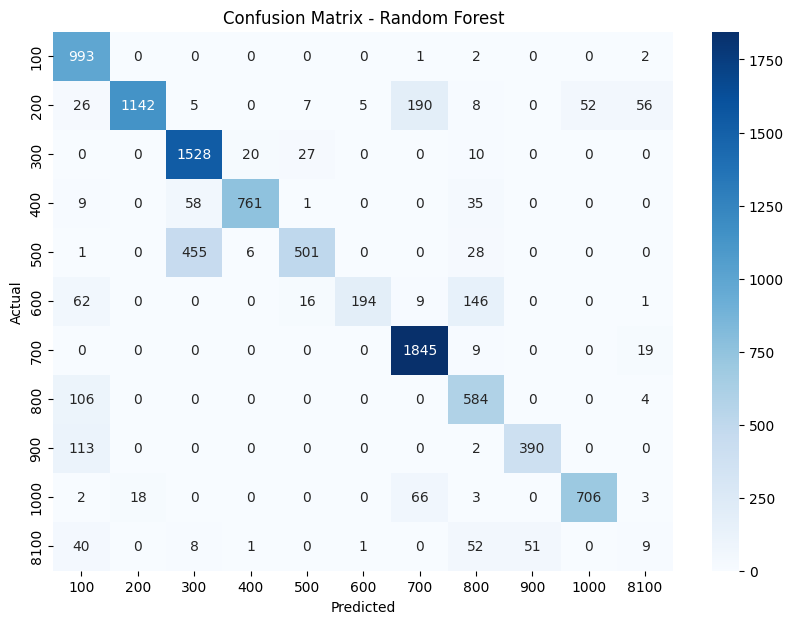


🔍 Đang huấn luyện mô hình: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         100       0.76      0.97      0.85       998
         200       0.98      0.67      0.80      1491
         300       0.74      0.84      0.79      1585
         400       0.91      0.90      0.91       864
         500       0.75      0.43      0.55       991
         600       0.52      0.64      0.58       428
         700       0.92      0.96      0.94      1873
         800       0.72      0.96      0.83       694
         900       0.96      0.69      0.80       505
        1000       0.90      0.91      0.91       798
        8100       0.18      0.33      0.24       162

    accuracy                           0.81     10389
   macro avg       0.76      0.76      0.74     10389
weighted avg       0.83      0.81      0.80     10389



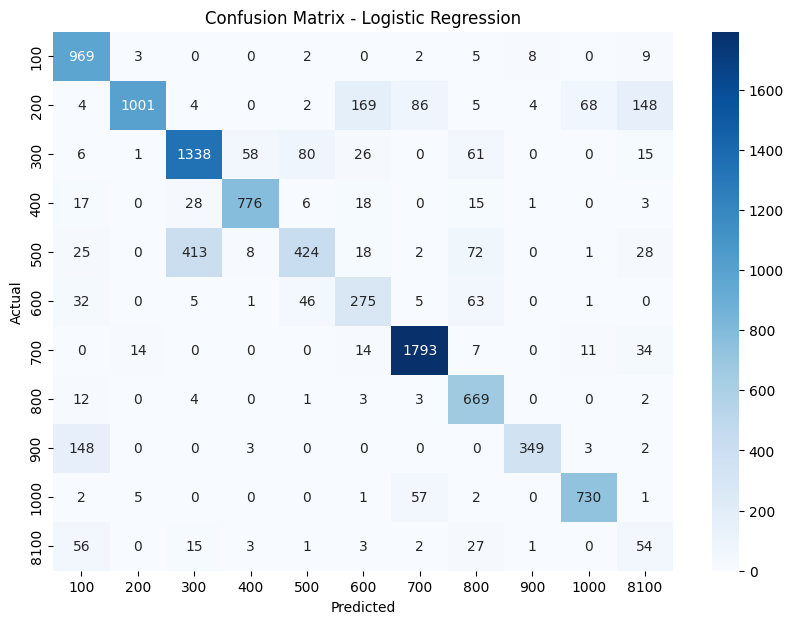


🔍 Đang huấn luyện mô hình: Extra Trees
              precision    recall  f1-score   support

         100       0.73      1.00      0.85       998
         200       0.98      0.76      0.86      1491
         300       0.72      0.98      0.83      1585
         400       0.97      0.90      0.93       864
         500       0.91      0.46      0.61       991
         600       0.97      0.47      0.64       428
         700       0.87      1.00      0.93      1873
         800       0.72      0.88      0.79       694
         900       0.90      0.72      0.80       505
        1000       0.93      0.88      0.90       798
        8100       0.17      0.07      0.10       162

    accuracy                           0.83     10389
   macro avg       0.81      0.74      0.75     10389
weighted avg       0.85      0.83      0.82     10389



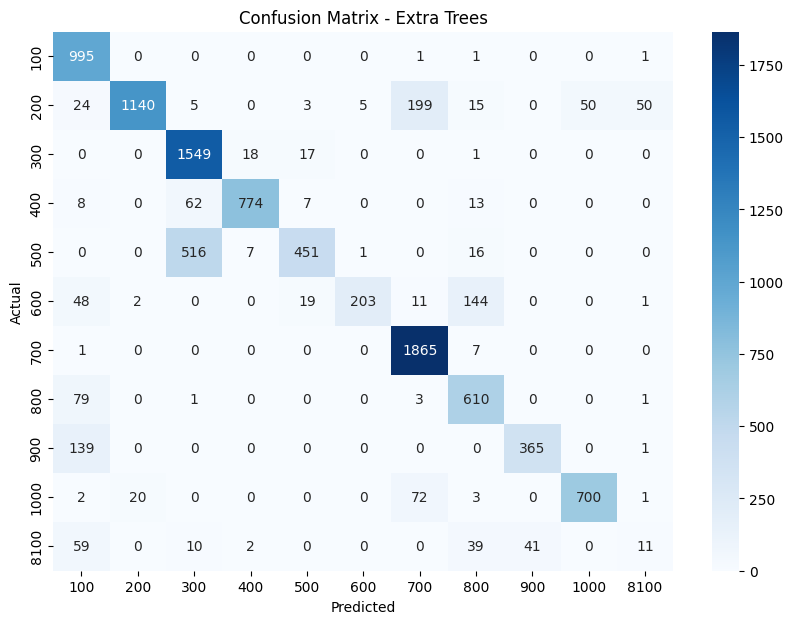


🔍 Đang huấn luyện mô hình: KNN (K-Nearest Neighbors)
              precision    recall  f1-score   support

         100       0.55      0.88      0.68       998
         200       0.71      0.44      0.55      1491
         300       0.62      0.23      0.33      1585
         400       0.83      0.79      0.81       864
         500       0.30      0.22      0.26       991
         600       0.18      0.36      0.24       428
         700       0.76      0.73      0.75      1873
         800       0.45      0.56      0.50       694
         900       0.82      0.48      0.61       505
        1000       0.59      0.75      0.66       798
        8100       0.03      0.18      0.05       162

    accuracy                           0.54     10389
   macro avg       0.53      0.51      0.49     10389
weighted avg       0.61      0.54      0.55     10389



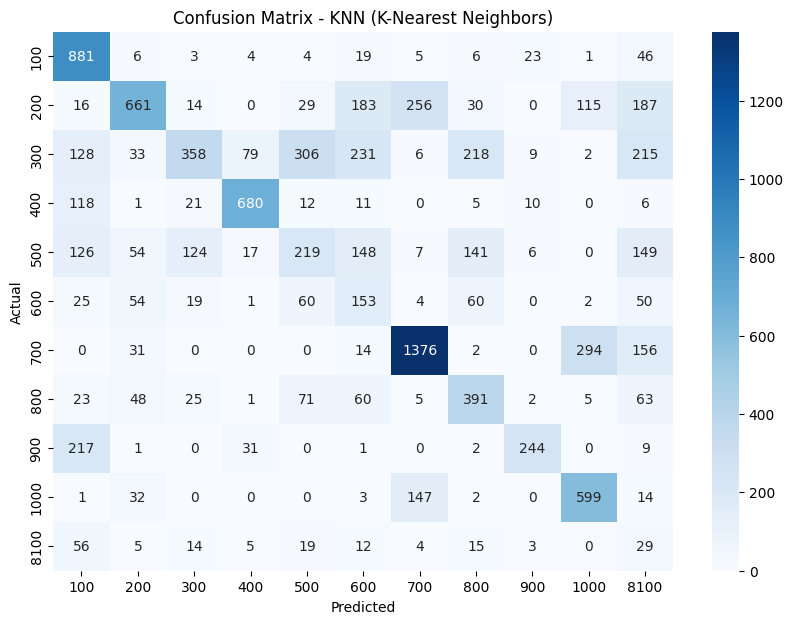


🔍 Đang huấn luyện mô hình: XGBoost
              precision    recall  f1-score   support

         100       0.76      1.00      0.87       998
         200       0.99      0.60      0.74      1491
         300       0.75      0.97      0.85      1585
         400       0.95      0.92      0.94       864
         500       0.80      0.50      0.61       991
         600       1.00      0.25      0.41       428
         700       0.85      0.97      0.91      1873
         800       0.66      0.85      0.74       694
         900       0.90      0.90      0.90       505
        1000       0.83      0.87      0.85       798
        8100       0.06      0.08      0.07       162

    accuracy                           0.81     10389
   macro avg       0.78      0.72      0.72     10389
weighted avg       0.83      0.81      0.80     10389



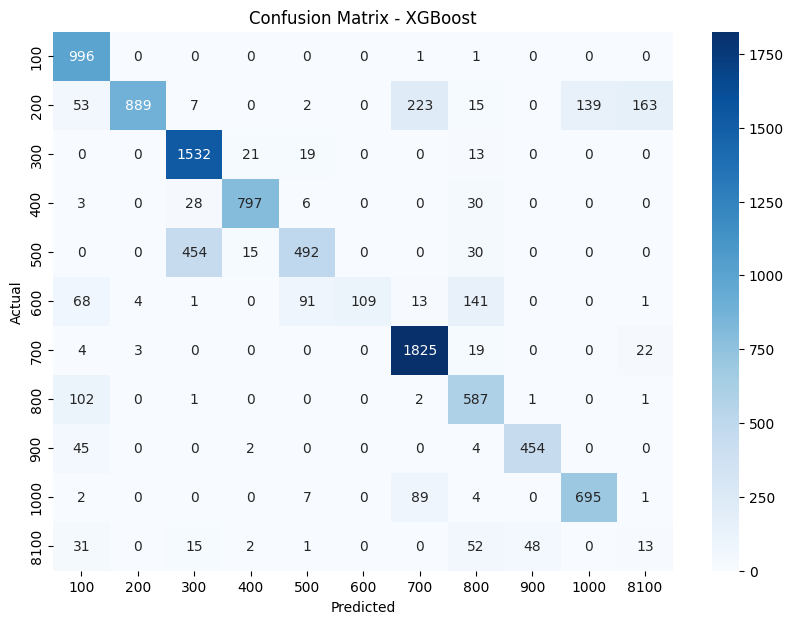


🔍 Đang huấn luyện mô hình: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.288631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45996
[LightGBM] [Info] Number of data points in the train set: 93687, number of used features: 206
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

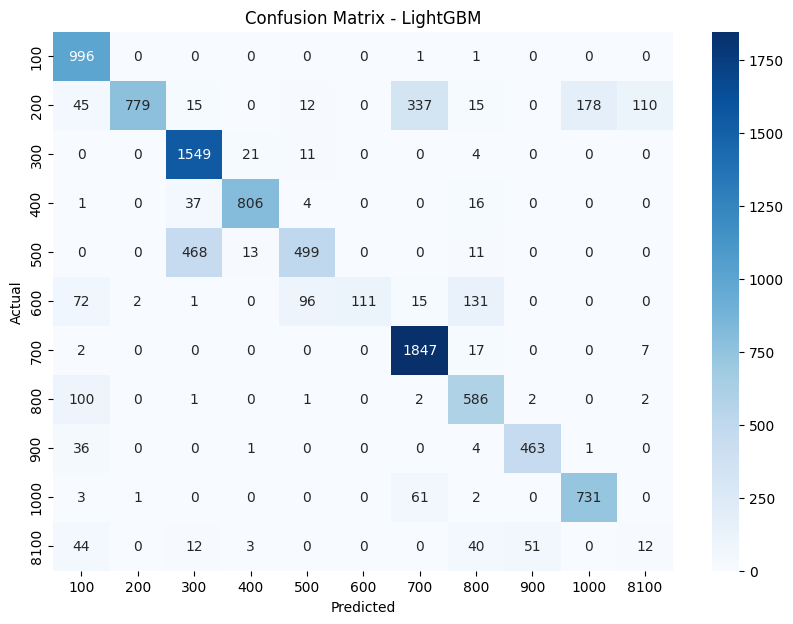

In [28]:
# Các model sẽ thử nghiệm
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "KNN (K-Nearest Neighbors)": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier
     (
        n_estimators=200,
        learning_rate=0.1
      )
}

# Huấn luyện và đánh giá từng model
for model_name, model in models.items():
    print(f"\n🔍 Đang huấn luyện mô hình: {model_name}")
    model.fit(X_train_resampled, y_train_resampled)

    y_pred_encoded = model.predict(X_test)

    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_test_original = label_encoder.inverse_transform(y_test_encoded)

    print(classification_report(y_test_original, y_pred))

    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_test_original, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()